# labeling dataset by placing words on SOM

In [1]:
import numpy as np # pip install numpy
import cv2 # pip install opencv-python
from matplotlib import pyplot as plt # pip install matplotlib
import os
import json

In [2]:
import cem_mini
from cem_mini import plot_cem_form
import dataset

In [3]:
import sompy
import som_util
import logging
logging.root.setLevel(logging.ERROR)

In [4]:
cem_dataset=dataset.get_dataset_from_file(r'..\cem-dataset\cem-towers\SDML_CEM.py')

In [5]:
import math

def _check_form(form,ax,view):
    plot_cem_form(ax,form['coords'],form['edges'],form['forces'],view=view,thickness_base=0.5,thickness_ratio=0.02)

def check_forms(forms,axis='off',view='3D-45',titles=None, title_offset=None, fname=None):
    if type(forms) is list:
        rows = int(len(forms)**0.5)
        cols = int(math.ceil(len(forms) / rows))
        
        fig=plt.figure(figsize=(16,int(16/cols*rows)))
        
        show_title=type(titles) is list
        
        for i in range(len(forms)):
            ax=fig.add_subplot(rows, cols, i+1, projection='3d')
            _check_form(forms[i],ax,view)
            plt.axis(axis)
            if show_title:
                plt.title(titles[i],y=title_offset)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()
    elif type(forms) is dict:
        plt.figure(figsize=(8,8))
        ax=plt.axes(projection='3d')
        _check_form(forms,ax,view)
        plt.axis(axis)
        if type(titles) is str:
            plt.title(titles,y=title_offset)
            
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()

In [6]:
# for tower dataset only
# add feature names which get node_xyz by floors
floor_num=10
node_per_floor=16
dev_edge_per_floor=24

trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()

In [7]:
trail_length_per_path=[[cem_dataset.name_dict['trail_length'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]
trail_mag_per_path=[[cem_dataset.name_dict['trail_mag'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]

In [8]:
node_x_per_trail=[[cem_dataset.name_dict['node_x'][i] for i in t] for t in trail_path]
node_y_per_trail=[[cem_dataset.name_dict['node_y'][i] for i in t] for t in trail_path]
node_z_per_trail=[[cem_dataset.name_dict['node_z'][i] for i in t] for t in trail_path]

In [9]:
node_x_by_floor=[cem_dataset.name_dict['node_x'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_y_by_floor=[cem_dataset.name_dict['node_y'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_z_by_floor=[cem_dataset.name_dict['node_z'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]

dev_mag_by_floor=[cem_dataset.name_dict['dev_mag'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]
dev_length_by_floor=[cem_dataset.name_dict['dev_length'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]

In [10]:
for i in range(floor_num+1):
    cem_dataset.name_dict['node_x_%d'%i]=node_x_by_floor[i]
    cem_dataset.name_dict['node_y_%d'%i]=node_y_by_floor[i]
    cem_dataset.name_dict['node_z_%d'%i]=node_z_by_floor[i]

for i in range(floor_num):
    cem_dataset.name_dict['dev_length_%d'%i]=dev_length_by_floor[i]
    cem_dataset.name_dict['dev_mag_%d'%i]=dev_mag_by_floor[i]

for i in range(node_per_floor):
    cem_dataset.name_dict['trail_length_%d'%i]=trail_length_per_path[i]
    cem_dataset.name_dict['trail_mag_%d'%i]=trail_mag_per_path[i]
    cem_dataset.name_dict['node_x_trail-%d'%i]=node_x_per_trail[i]
    cem_dataset.name_dict['node_y_trail-%d'%i]=node_y_per_trail[i]
    cem_dataset.name_dict['node_z_trail-%d'%i]=node_z_per_trail[i]

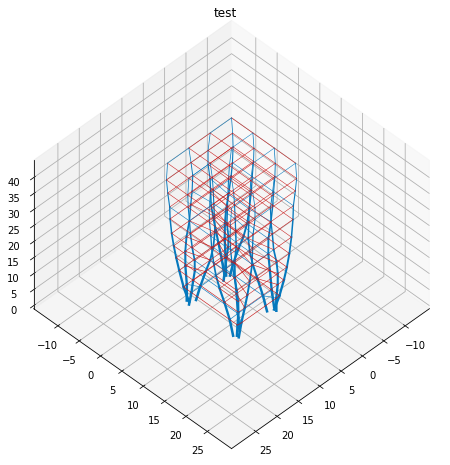

In [11]:
check_forms(cem_dataset.get_forms(0),'on',titles='test')

## load som

fft som

In [12]:
mapsize = [12,12]
mapsize_str='x'.join([str(i) for i in mapsize])
mapsize_str

'12x12'

In [13]:
feature_code="node_x_trail-0_lowpass-real3-node_y_trail-15_lowpass-imag3-(64)"

In [14]:
fft_base_functions={
#     'lowpass-real5':lambda x:x.real[...,:5], # the 1st freq decides the mean value
#     'lowpass-imag5':lambda x:x.imag[...,:5], # the 1st freq decides the mean value

    'lowpass-real3':lambda x:x.real[...,:3], # the 1st freq decides the mean value
    'lowpass-imag3':lambda x:x.imag[...,:3], # the 1st freq decides the mean value
}
fft_target_features=[n%i for i in range(node_per_floor) for n in ['node_x_trail-%d','node_y_trail-%d']]

def create_FFT_feature_extractor(feature_name, method):
    '''
    assume x is a matrix where the columns are features
    this function returns a callable f(x) that can be represented as this persudo code:
    
    f(x) = method(x[...,get_column_from_name(feature_name)],axis=-1)
    '''
    return lambda x: method(np.fft.fft(x.get_vector(range(x.get_num_samples()), feature_name),axis=-1))

# hos_feature_base_extractors: a list of callables,
# each one of them calculate A HOS VALUE from A FEATURE NAME of ALL entries of the dataset
fft_feature_base_extractors=[create_FFT_feature_extractor(t,fft_base_functions[k]) for t in fft_target_features for k in fft_base_functions]
fft_feature_names=[t + '_' + k for t in fft_target_features for k in fft_base_functions]

# hos_feature_extractor: call all hos_feature_base_extractors, and concatenate the results along the last axis
fft_feature_extractor=lambda x:np.concatenate([f(x) for f in fft_feature_base_extractors],axis=-1)

fft_feature_code=fft_feature_names[0] + '-' + fft_feature_names[-1] + '-(%d)'%len(fft_feature_names)
feature_code = fft_feature_code

training_vector_som=fft_feature_extractor(cem_dataset)
training_vector_som.shape

(4727, 192)

som data

In [16]:
som=som_util.load_som_from_file(os.path.join('../outputs/SOMs','som_%s_%s_%s.zip'%(mapsize_str,feature_code,cem_dataset.get_dataset_name())))

dataraw is not given nor can be read from file, use random data instead (the bmu is not anymore valid)


som rendering

In [17]:
import io
import zipfile

In [28]:
def read_bytes_from_zip(zf, name):
    with zf.open(name) as f:
        d=f.read()
    return d

with zipfile.ZipFile(os.path.join('../outputs/SOMs','som_%s_%s_%s_rendering.zip'%(mapsize_str,feature_code,cem_dataset.get_dataset_name()))) as zf:
    cells=[cv2.imdecode(np.frombuffer(read_bytes_from_zip(zf, 'cell-%d.jpg'%i),dtype=np.uint8), cv2.IMREAD_COLOR) for i in range(mapsize[0]*mapsize[1])]

In [29]:
cell_trim=450
cell_size=(128,128)

cell_trim=([c[cell_trim:-cell_trim,cell_trim:-cell_trim] for c in cells] if cell_size is None else [cv2.resize(c[cell_trim:-cell_trim,cell_trim:-cell_trim],cell_size) for c in cells])

In [30]:
rows=[np.concatenate(cell_trim[i*mapsize[1]:i*mapsize[1]+mapsize[1]],axis=1) for i in range(mapsize[0])]
background=np.concatenate(rows,axis=0)

## labeller

In [22]:
import ipywidgets as widgets
from IPython.display import display

import json

In [23]:
import math

def gaussian_w(dist, sigma, weight):
    return weight / (sigma*2.50662827463) * math.exp(-0.5 * (dist/sigma)**2)

def get_max_gaussian(sigma):
    return 1/(sigma*2.50662827463)

def reverse_gaussian(y, sigma):
    '''
    get the corresponding x from gaussian function f(x)=y
    where f(x)=1/(sigma*sqrt(2pi)) * exp(-0.5(x/sigma)^2)
    '''
    c=get_max_gaussian(sigma)
    y=max(0,min(y,c))
    
    return sigma * (-2 * math.log(y/c))**0.5

In [24]:
import matplotlib

from matplotlib.patches import Ellipse, Rectangle

color_forground=(230/255,40/255,40/255)
color_background=(0.35,0.35,0.35)#(74/255,112/255,230/255)

class LabelerFreeTextOnSOM():
    def __init__(self, map_size, background, widgets_output, save_to=None, display_range=[0.9,0.1]):
        '''
        --- parameters ---
        background: background som rendering
        widgets_output: widgets.Output object
        save_to: file path, where to save the label file
        '''
        self.h, self.w=map_size
        self.h_pixel, self.w_pixel = background.shape[:2]
        self.h_size=self.h_pixel/self.h
        self.w_size=self.w_pixel/self.w

        self.widgets_output = widgets_output
        self.save_to=save_to
        self.display_range=display_range
        
        self.words_counter=0 # word indentifier, +1 everytime a new word is added. will not decrease even the previous words are removed
        self._add_gui()

        self.labels={}
        self._init_plot(background)


    def _init_plot(self, background):
        self.fig, self.ax = plt.subplots(figsize=(8,8))
        self.ax.imshow(background)
        self.fig.suptitle('Labeled SOM', fontsize=16)
        self.ax.set_title('Circle radius represent the 90% and 10% percentiles\ntext size represents weight')

        # set figure xy sticks
        x_ticks_pos=[self._to_grid_pos_x_relative(i/(self.w-1)) for i in range(self.w)]
        y_ticks_pos=[self._to_grid_pos_y_relative(i/(self.h-1)) for i in range(self.h)]
#         self.ax.set_xticks(x_ticks_pos)
#         self.ax.set_yticks(y_ticks_pos)
#         self.ax.set_xticklabels(range(self.w))
#         self.ax.set_yticklabels(range(self.h))
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        
        self.artist_text={} # texts in the graphical plot
        self.artist_element={} # circles (ellipses) in the graphical plot, to show the radius
        self.artist_grid=[] # grid elements in the graphical plot, to show the radius
        
        for i in range(self.h):
            for j in range(self.w):
#                 indice=i*self.w+j
                y0=int(i/self.h*self.h_pixel)
                x0=int(j/self.w*self.w_pixel)
                
                p=Rectangle((x0, y0), self.w_size, self.h_size, linewidth=1, edgecolor='none', facecolor='none')
                self.ax.add_patch(p)
                self.artist_grid.append(p)
        
    def _to_grid_pos_x_relative(self,x):
        '''
        map [0,1] to display grid position
        '''
        return  x * (self.w_pixel-self.w_size) + self.w_size/2
    
    def _to_grid_pos_y_relative(self,y):
        '''
        map [0,1] to display grid position
        '''
        return  y * (self.h_pixel-self.h_size) + self.h_size/2
    
    def _to_pixel_size_x(self,x):
        '''
        map cell_size to display size
        i.e., 0 > 0, i > i*self.w_size
        '''
        return  x * self.w_size
    
    def _to_pixel_size_y(self,y):
        '''
        map cell_size to display size
        i.e., 0 > 0, i > i*self.h_size
        '''
        return  y * self.h_size
    
    def _add_gui(self):
        self.add_button = widgets.Button(description='Add')
        self.add_button.on_click(self._add_text)
        self.rmv_button = widgets.Button(description='Remove')
        self.rmv_button.on_click(self._remove_text)
        
        self.text_box = widgets.Text(description='new', placeholder='type new words here', value='')
        # important: should allow same word showing up multiple times
        self.text_list = widgets.Dropdown(placeholder='choose words', options=[], description='current')
        self._observe_drop_list()
        
        self.x_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='x', orientation='horizontal', readout=True, readout_format='.2f')
        self.y_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='y', orientation='horizontal', readout=True, readout_format='.2f')
        self.w_slider = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.01, description='weight', orientation='horizontal', readout=True, readout_format='.2f')
        self.sigma_slider = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.01, description='sigma', orientation='horizontal', readout=True, readout_format='.2f')
        self._observe_sliders()
        
        self.show_current_button = widgets.Button(description="Show Current Labels")
        self.save_current_button = widgets.Button(description="Save Current Labels")
        self.show_current_button.on_click(self._show_current_labels)
        self.save_current_button.on_click(self._save_current_labels)

        add_box = widgets.HBox(children=[self.add_button, self.text_box])
        rmv_box = widgets.HBox(children=[self.rmv_button, self.text_list])
        show_box= widgets.VBox(children=[self.show_current_button, self.save_current_button])
        
        head_layout=widgets.VBox(children=[add_box, rmv_box, show_box])
        adj_layout=widgets.VBox(children=[self.x_slider,self.y_slider,self.w_slider,self.sigma_slider])

        self.disp_layout=widgets.HBox([head_layout, adj_layout])
        
    def run_labeler(self):
        display(self.disp_layout, self.widgets_output)
        with self.widgets_output:
            plt.show(self.fig)

    def _save_current_labels(self, b):
        if self.save_to is not None:
            with open(self.save_to,"w") as file:
                json.dump(self.labels, file)
        
    def _show_current_labels(self, b):
        self.widgets_output.clear_output()
        with self.widgets_output:
            plt.show(self.fig) # plot figure
            for k in self.labels.keys():
                print(k, ">", self.labels[k])
    
    def _unobserve_drop_list(self):
        self.text_list.unobserve(self._on_list_click,'value')
    
    def _observe_drop_list(self):
        self.text_list.observe(self._on_list_click,'value')
    
    def _unobserve_sliders(self):
        self.x_slider.unobserve(self._on_value_change,'value')
        self.y_slider.unobserve(self._on_value_change,'value')
        self.w_slider.unobserve(self._on_value_change,'value')
        self.sigma_slider.unobserve(self._on_value_change,'value')
        
    def _observe_sliders(self):
        self.x_slider.observe(self._on_value_change,'value')
        self.y_slider.observe(self._on_value_change,'value')
        self.w_slider.observe(self._on_value_change,'value')
        self.sigma_slider.observe(self._on_value_change,'value')
    
    def _create_display_disks(self, sig):
        max_y = get_max_gaussian(sig)
        return [reverse_gaussian(max_y*r, sig) for r in self.display_range] 
    
    def __get_fontsize(self, w):
        return 3+w*15
    
    def __process_add(self, k_add):
        for k in k_add:
            x=self._to_grid_pos_x_relative(self.labels[k]['x'])
            y=self._to_grid_pos_y_relative(self.labels[k]['y'])
            w=self.labels[k]['weight']
            word=self.labels[k]['key']
            self.artist_text[k]=self.ax.text(x,y,word,verticalalignment='center',horizontalalignment='center')#,fontsize=self.__get_fontsize(w))
            
            sig=self.labels[k]['sigma']
            radius=self._create_display_disks(sig)
            
            patches=[Ellipse((x,y),self._to_pixel_size_x(r)*2,self._to_pixel_size_y(r)*2,fill=False,edgecolor='black') for r in radius]
            for i,p in zip(range(len(radius)),patches):
                self.ax.add_patch(p)
                self.artist_element['%d-%d'%(k,i)]=p
    
    def __process_show(self, k_to_show):
        for k in k_to_show:
            x=self._to_grid_pos_x_relative(self.labels[k]['x'])
            y=self._to_grid_pos_y_relative(self.labels[k]['y'])
            w=self.labels[k]['weight']
            # update text position
            self.artist_text[k].set_x(x)
            self.artist_text[k].set_y(y)
#             self.artist_text[k].set_fontsize(self.__get_fontsize(w))
            if k == self.text_list.value:
                self.artist_text[k].set_color(color_forground)
            else:
                self.artist_text[k].set_color(color_background)
            # update circle's radius and positions
            sig=self.labels[k]['sigma']
            radius=self._create_display_disks(sig)
            
            for i in range(len(radius)):
                r=radius[i]
                self.artist_element['%d-%d'%(k,i)].set_center((x,y))
                self.artist_element['%d-%d'%(k,i)].set_height(self._to_pixel_size_x(r)*2)
                self.artist_element['%d-%d'%(k,i)].set_width(self._to_pixel_size_y(r)*2)
                
                if k == self.text_list.value:
                     self.artist_element['%d-%d'%(k,i)].set_edgecolor((*color_forground, 1-i/len(radius)))
                else:
                     self.artist_element['%d-%d'%(k,i)].set_edgecolor((*color_background, 1-i/len(radius)))
                        
    def __process_current(self, k_to_show):
        k=self.text_list.value
        if k in k_to_show:
            # important here: mapsize - 1
            x=self.labels[k]['x'] * (self.w-1)
            y=self.labels[k]['y'] * (self.h-1)
            w=self.labels[k]['weight']
            sig=self.labels[k]['sigma']
            
            for i in range(self.h):
                for j in range(self.w):
                    indice=i*self.w+j
                    dist=((x-j)**2+(y-i)**2)**0.5
                    alpha=gaussian_w(dist,sig, w)
#                     print(dist, alpha)
                    self.artist_grid[indice].set_facecolor((*color_forground,min(1, alpha)))
                
        else:
            for p in self.artist_grid:
                p.set_facecolor('none')

    def __process_remove(self, k_remove):
        for k in k_remove:
            self.artist_text[k].remove()
            if self.artist_text[k] in self.ax.texts:
                # fail to remove (plt bug?), set visible to false
                self.artist_text[k].set_visible(False)
            else:
                # successed
                self.artist_text.pop(k)
            
            for i in range(len(self.display_range)):
                k2='%d-%d'%(k,i)
                self.artist_element[k2].remove()
                if self.artist_element[k2] in self.ax.patches:
                    # fail to remove (plt bug?), set visible to false
                    self.artist_element[k2].set_visible(False)
                else:
                    # successed
                    self.artist_element.pop(k2)
                    
    def _update_graphics(self):
        '''
        update the embedded figure / visualization
        '''
        k_showing=set(self.artist_text.keys())
        k_to_show=set(self.labels.keys())
        
        k_add=k_to_show-k_showing
        k_remove=k_showing-k_to_show
        self.__process_add(k_add)
        self.__process_show(k_to_show)
        self.__process_current(k_to_show)
        self.__process_remove(k_remove)

    def _add_text(self, b):
        if self.text_box.value != '':
            # disable observe
            self._unobserve_drop_list()
            options=list(self.text_list.options)
            options.append((self.text_box.value, self.words_counter))
            self.text_list.options=options
            # enable observe
            self._observe_drop_list()

            # add labels to the dictionary
            self.labels[self.words_counter]={'key':self.text_box.value, 'x':0.5, 'y':0.5, 'weight':1, 'sigma':1} # default value
            self.words_counter += 1 # counter +1
            self.text_box.value=''
            self._update_graphics()
            
            # move to the recent-add
            self.text_list.value=self.words_counter-1
    
    def _remove_text(self, b):
        k = self.text_list.value
        if k is not None:
            options=[[tag,val] for tag, val in self.text_list.options if val!=k]
            self.text_list.options=options
            self.labels.pop(k, None)
            self._update_graphics()
    
    def _on_list_click(self, b):
        k = self.text_list.value
        if k is not None:
            self._unobserve_sliders()
            
            self.x_slider.value=self.labels[k]['x']
            self.y_slider.value=self.labels[k]['y']
            self.w_slider.value=self.labels[k]['weight']
            self.sigma_slider.value=self.labels[k]['sigma']
            
            self._observe_sliders()
        self.__process_show(self.labels.keys())
        self.__process_current(self.labels.keys())

    def _on_value_change(self, s):
        s=s['owner']
        k = self.text_list.value
        if k in self.labels.keys():
            self.labels[k][s.description] = s.value
            self._update_graphics()

    def _check_label(self):
        # check label set
        key=str(self.jpg_files[self.index])
        if key not in self.labels.keys():
            self.labels[key] = []

        for b in self.lb_button:
            if b.description in self.labels[key]:
                b.style.button_color='darkgray'
            else:
                b.style.button_color = self.next_button.style.button_color
    
    def load_exist_label(self, label_file):
        with open(label_file) as f:
            label_data=json.load(f)
        
        for k in label_data.keys():
            self.labels[int(k)]=label_data[k]
        
        self.words_counter=max(self.labels.keys())+1
        
        self._unobserve_drop_list()
        options = [(self.labels[i]['key'], i)for i in range(self.words_counter) if i in self.labels.keys()]
        self.text_list.options=options
        self._observe_drop_list()
        self._update_graphics()
        self._on_list_click(None)

In [25]:
user_name='guo-12x12'

label_file=r'..\outputs\labels\%s-labels.json'%user_name

In [26]:
dataset.SELECTED_KEYWORDS

['simple',
 'strong',
 'light',
 'natural',
 'architectural',
 'unique',
 'like',
 'clear',
 'potential',
 'interesting',
 'open',
 'different',
 'sustainable',
 'central',
 'internal',
 'designed',
 'structural',
 'vertical',
 'great',
 'large',
 'high',
 'modular',
 'living',
 'beautiful',
 'compelling',
 'small',
 'flexible',
 'quality',
 'spatial',
 'low',
 'rich',
 'poetic',
 'integrated',
 'innovative',
 'linear',
 'curved',
 'typical',
 'adaptable',
 'convincing',
 'historic',
 'effective',
 'thoughtfull',
 'complex',
 'multiple',
 'connected',
 'iconic',
 'stacked',
 'single',
 'symbolic',
 'transparent',
 'organized',
 'solid',
 'enclosed',
 'shaped',
 'filled',
 'impressive',
 'refined',
 'tectonic',
 'ephemeral',
 'affordable',
 'supported',
 'alternative',
 'restrained',
 'elegant',
 'long',
 'balanced',
 'minimal',
 'heavy']

In [38]:
%matplotlib widget

widgets_output = widgets.Output()
labeler=LabelerFreeTextOnSOM(mapsize,background[...,::-1],widgets_output, save_to=label_file)
labeler.run_labeler()

if os.path.exists(label_file):
    labeler.load_exist_label(label_file)

Output()

## calculate numerical values for each cell

In [39]:
user_name='guo-12x12'

label_file=r'..\outputs\labels\%s-labels.json'%user_name

with open(label_file) as f:
    label_data=json.load(f)

label_data=[label_data[k] for k in label_data.keys()]
label_data

[{'key': 'thin', 'x': 1.0, 'y': 0.0, 'weight': 4.18, 'sigma': 3.49},
 {'key': 'thick', 'x': 0.0, 'y': 1.0, 'weight': 5.0, 'sigma': 5.0},
 {'key': 'thick', 'x': 0.0, 'y': 0.0, 'weight': 1.0, 'sigma': 1.87},
 {'key': 'thick', 'x': 1.0, 'y': 1.0, 'weight': 2.15, 'sigma': 2.39},
 {'key': 'simple', 'x': 0.08, 'y': 0.91, 'weight': 1, 'sigma': 1},
 {'key': 'simple', 'x': 0.1, 'y': 0.09, 'weight': 1, 'sigma': 1},
 {'key': 'twisted', 'x': 0.67, 'y': 0.29, 'weight': 1, 'sigma': 0.69},
 {'key': 'twisted', 'x': 0.73, 'y': 0.81, 'weight': 1.12, 'sigma': 1.01},
 {'key': 'heavy', 'x': 0.21, 'y': 0.72, 'weight': 1.24, 'sigma': 1.12},
 {'key': 'heavy', 'x': 1.0, 'y': 1.0, 'weight': 1, 'sigma': 0.76},
 {'key': 'twisted', 'x': 0.38, 'y': 0.28, 'weight': 0.45, 'sigma': 0.61},
 {'key': 'twisted', 'x': 0.27, 'y': 0.55, 'weight': 0.65, 'sigma': 0.57},
 {'key': 'twisted', 'x': 0.67, 'y': 1.0, 'weight': 1, 'sigma': 1},
 {'key': 'heavy', 'x': 0.31, 'y': 0.0, 'weight': 0.84, 'sigma': 0.65},
 {'key': 'heavy', 'x'

In [40]:
all_keywords=sorted(list(set([l['key'] for l in label_data])))
all_keywords

['balanced',
 'heavy',
 'iconic',
 'simple',
 'thick',
 'thin',
 'twisted',
 'unbalanced']

In [41]:
import math

def gaussian(dist, sigma, weight):
    return weight / (sigma*2.50662827463) * math.exp(-0.5 * (dist/sigma)**2)

def numerical_value_to(xy, mapsize, label):
    x,y=xy
    
    # important here: mapsize - 1
    x0=label['x'] * (mapsize[1]-1)
    y0=label['y'] * (mapsize[0]-1)
    
    dist=((x-x0)**2+(y-y0)**2)**0.5
    return label['key'], gaussian(dist, label['sigma'],label['weight'])

def numerical_value_to_all(xy, mapsize, all_labels, keys=None):
    values=[numerical_value_to(xy, mapsize, l) for l in all_labels]
    
    # generate keys (keywords) from the results
    if keys is None:
        keys=sorted(list(set([k for k,_ in values])))
    else:
        if len(set(keys))!=len(keys):
            raise Exception('please delete duplications in keys')
            
    output_array=[0]*len(keys)
    
    # as the same keyword may exist many times in the labels
    keys_to_indice={keys[i]:i for i in range(len(keys))}
    for k,v in values:
        if k in keys_to_indice.keys():
            i=keys_to_indice[k]
            output_array[i]+=v
    
    output_array=np.asarray(output_array)
    # normalization
#     return output_array/((output_array**2).sum()**0.5), keys
    return output_array/output_array.sum(), keys

In [42]:
text_label_all_cells=np.asarray([[numerical_value_to_all((col,row),mapsize, label_data, all_keywords)[0] for col in range(mapsize[1])] for row in range(mapsize[0])])
text_label_all_cells.shape

(12, 12, 8)

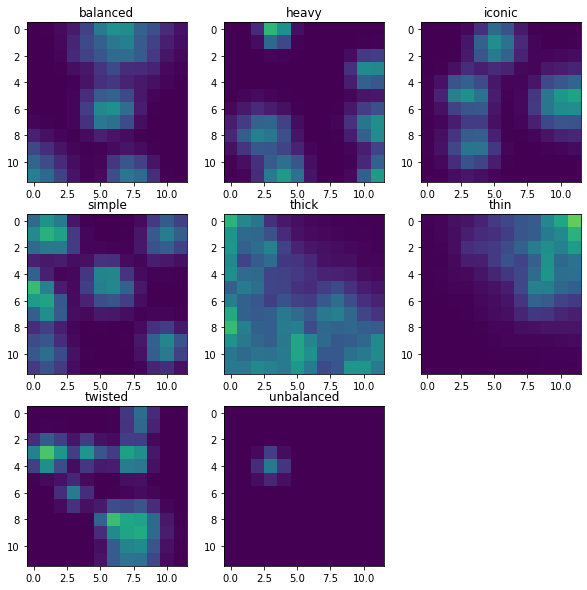

In [43]:
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(text_label_all_cells.shape[-1]):
    plt.subplot(3,3,i+1)
    plt.imshow(text_label_all_cells[...,i],vmax=1,vmin=0)
    plt.title(all_keywords[i])
plt.show()

### save these grayscale images for IASS presentation

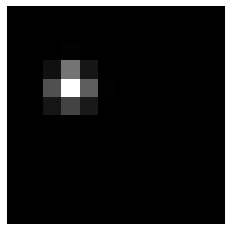

In [81]:
for i in range(text_label_all_cells.shape[-1]):
    plt.close()
    plt.axis('off')
    plt.imshow(text_label_all_cells[...,i],vmin=0,cmap='gray')
    plt.savefig('../output_IASS2022/label_%s.png'%all_keywords[i], bbox_inches='tight', dpi=600)

## labeling the dataset

compute the relation between a vector to all som cells, then generate the labels

using bagofwords?

- get euclidean distances
- normalize all distances
- "weighted sum" of all text labels based on the distances

In [44]:
import BoW_encoding as bow

In [45]:
from importlib import reload
bow=reload(bow)

In [46]:
reference_vector=som.codebook.matrix
reference_vector.shape

(144, 192)

In [47]:
# here is one-vector to all reference vectors,
# unlike the case of patch-based image search which is several-vectors to all reference vectors
# therefore we use no pooling function

# also, use prob_normalizer so that the result vector represents propability and can be used for weighted sum

bow_encoding=bow.high_level_encoding(reference_vector,
                                     bow.mid_level_coding(bow.inverse_euclidean_p1, None, bow.prob_normalizer(8)),
                                     lambda x:x) # no pooling method

In [48]:
normalized_training_vectors=data=som._normalizer.normalize_by(som.data_raw, training_vector_som)
normalized_training_vectors.shape

(4727, 192)

In [49]:
# the "activation" of each training sample on the SOM cells
activation_vector=bow_encoding(normalized_training_vectors)
activation_vector.shape

(4727, 144)

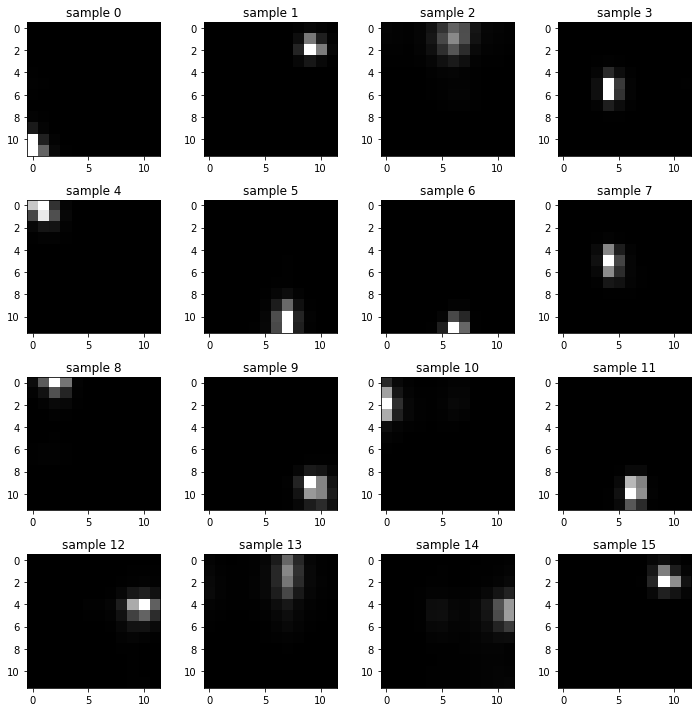

In [94]:
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
#     plt.plot(activation_vector[i])
#     plt.ylim(0,0.5)
    plt.imshow(activation_vector[i].reshape(mapsize),vmin=0,vmax=0.25,cmap='gray')
    plt.title('sample %d'%i)
plt.tight_layout()
plt.show()

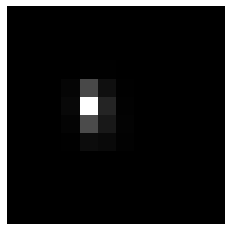

In [95]:
for i in range(8):
    plt.close()
    plt.axis('off')
    plt.imshow(activation_vector[i].reshape(mapsize),vmin=0,cmap='gray')
#     plt.show()
    plt.savefig('../output_IASS2022/sample_acti_som_%d.png'%i, bbox_inches='tight', dpi=600)

get the text label (as weighted sum of SOM cells' labels)

In [96]:
text_label_all_cells=np.asarray([numerical_value_to_all((col,row),mapsize, label_data, all_keywords)[0] for row in range(mapsize[0]) for col in range(mapsize[1])])
text_label_all_cells.shape # calculate as 1-d not 2-d

(144, 8)

In [97]:
labels_all_data = np.dot(activation_vector, text_label_all_cells)
labels_all_data.shape

(4727, 8)

save the results

In [106]:
user_name='guo-12x12'

label_vector_file=r'..\outputs\labels\%s-labels-vector.npy'%user_name
label_words_file=r'..\outputs\labels\%s-labels-vector-channel.csv'%user_name

np.save(label_vector_file, labels_all_data)

with open(label_words_file,'w') as f:
    f.write(','.join(all_keywords))

check some random results

In [98]:
indices=np.arange(cem_dataset.get_num_samples())
# np.random.shuffle(indices)
indices=indices[:16]
indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [99]:
labels_sampled_data=labels_all_data[indices]
forms_sampled_data=cem_dataset.get_forms(indices)

labels_sampled_data_str=['\n'.join(['%s-%.3f'%(t,v) for t,v in zip(all_keywords, vec)]) for vec in labels_sampled_data]
labels_sampled_data_str

['balanced-0.366\nheavy-0.012\niconic-0.005\nsimple-0.213\nthick-0.402\nthin-0.000\ntwisted-0.002\nunbalanced-0.000',
 'balanced-0.155\nheavy-0.051\niconic-0.017\nsimple-0.248\nthick-0.020\nthin-0.466\ntwisted-0.043\nunbalanced-0.000',
 'balanced-0.326\nheavy-0.026\niconic-0.218\nsimple-0.051\nthick-0.077\nthin-0.208\ntwisted-0.092\nunbalanced-0.002',
 'balanced-0.168\nheavy-0.031\niconic-0.279\nsimple-0.163\nthick-0.225\nthin-0.034\ntwisted-0.073\nunbalanced-0.026',
 'balanced-0.008\nheavy-0.016\niconic-0.003\nsimple-0.486\nthick-0.449\nthin-0.018\ntwisted-0.019\nunbalanced-0.001',
 'balanced-0.241\nheavy-0.016\niconic-0.005\nsimple-0.010\nthick-0.308\nthin-0.008\ntwisted-0.410\nunbalanced-0.000',
 'balanced-0.239\nheavy-0.058\niconic-0.003\nsimple-0.001\nthick-0.400\nthin-0.003\ntwisted-0.297\nunbalanced-0.000',
 'balanced-0.155\nheavy-0.020\niconic-0.274\nsimple-0.184\nthick-0.214\nthin-0.040\ntwisted-0.069\nunbalanced-0.044',
 'balanced-0.036\nheavy-0.168\niconic-0.013\nsimple-0.37

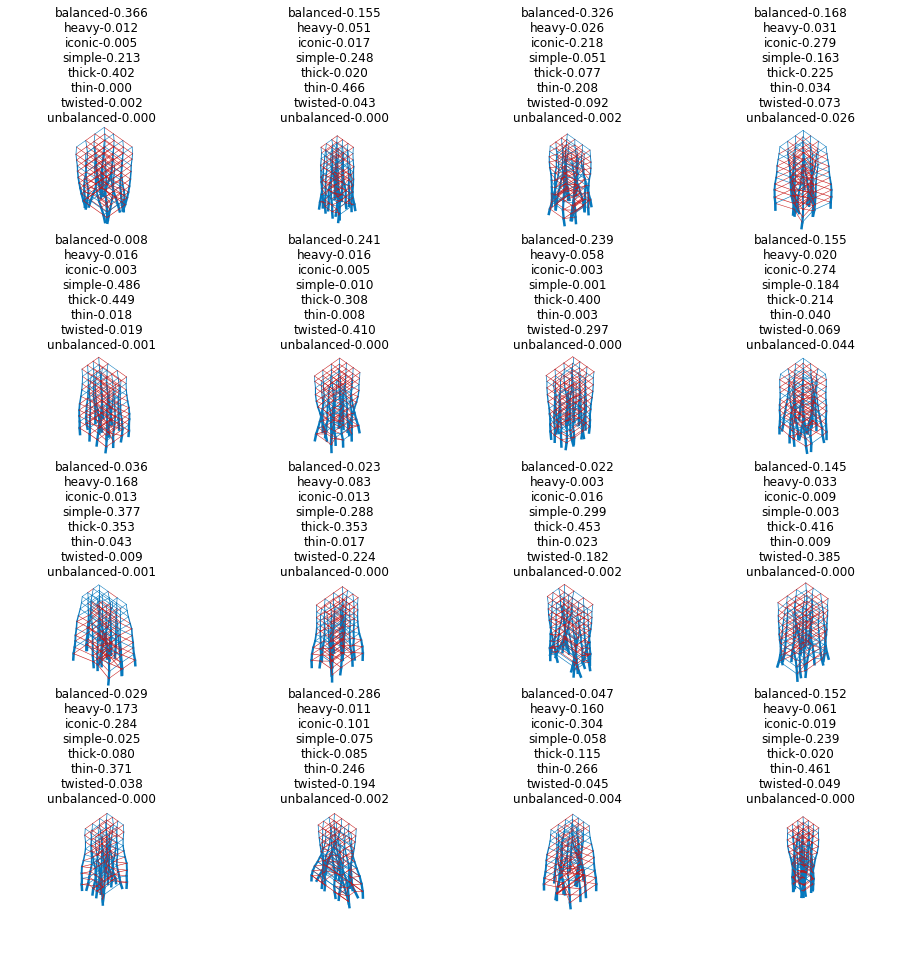

In [109]:
check_forms(forms_sampled_data,titles=labels_sampled_data_str,title_offset=0.85)#,fname=r'..\output\text_label_example.png')